# 1 신경망 복습

* 1.1 수학과 파이썬 복습 (pass)
* 1.2 신경망의 구조 (pass)
* 1.3 신경망의 학습
* 1.4 신경망으로 문제를 풀다
* 1.5 계산 고속화
* 1.6 정리

## 1.3 신경망의 학습

* 학습되지 않은 신경망은 '좋은 추론'을 해낼 수 없다.
* 신경망 학습은 최적의 매개변수 값을 찾는 작업이다. 

### 1.3.1 손실 함수

* 신경망 학습에서 사용하는 지표는 '손실'이다.
* '손실'은 학습 데이터와 신경망이 예측한 결과를 비교하여 얼마나 '나쁜가'를 나타낸다.
* 신경망의 손실은 '손실 함수'로 구한다.
* 다중 클래스 분류 신경망에서는 '교차 엔트로피 오차'를 사용한다.
* 교차 엔트로피 오차는 정답 레이블과 신경망의 출력 간의 오차를 나타낸다.

**소프트맥스 함수**
$$
y_{k} = \frac{exp(s_{k})}{\sum_{i=1}^{n}exp(s_{i})}
$$

* 출력이 총$n$개일 때, $k$번째 출력 $y_{k}$를 구하는 식이다.
* $y_{k}$는 $k$번째 클랙스에 해당하는 소프트맥스 함수의 출력이다.
* 소프트맥스 함수의 분자는 점수$s_{k}$의 지수 함수이고, 분모는 모든 클래스의 점수의 지수 함수의 합이다.
* 소프트맥스 함수의 출력은 0에서 1사이의 실수이며, 출력의 총합은 1이다.

**교차 엔트로피 오차**
$$
L = -\sum_{k}t_{k}log(y_{k})
$$

* $t_{k}$는 $k$번째 클래스에 해당하는 정답 레이블이다.
* log는 네이피어 상수 $e$를 밑으로 하는 자연로그이다.
* 정답 레이블은 원-핫 인코딩으로 표현한다.

**미니배치를 고려한 교차 엔트로피 오차**
$$
L = -\frac{1}{N}\sum_{n}\sum_{k}t_{nk}log(y_{nk})
$$

### 1.3.2 미분과 기울기

1.3.3 연쇄 법칙

* 신경망의 기울기는 '오차역전파법'으로 구한다.

1.3.4 계산 그래프

* 계산 그래프는 계산 과정을 그래프로 나타낸 것이다.

### 1.3.5 기울기 도출과 역전파 구현

**Sigmoid 계층**

시그모이드의 함수는 $$y = \frac{1}{1+exp(-x)}$$
시그모이드의 미분은 $$\frac{dy}{dx} = y(1-y)$$

In [39]:
class Sigmoid:
  def __init__(self):
    self.params, self.grads = [], []
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out
    return dx

In [40]:
# test Sigmod class

x = np.array([[1.0, -0.5], [-2.0, 3.0]])
sigmoid = Sigmoid()
print(sigmoid.forward(x))
sigmoid.out = sigmoid.forward(x)
print(sigmoid.backward(1))
print(sigmoid.backward(1).shape)
print(sigmoid.backward(1).dtype)


[[0.73105858 0.37754067]
 [0.11920292 0.95257413]]
[[0.19661193 0.23500371]
 [0.10499359 0.04517666]]
(2, 2)
float64


**Affine 계층**

Affine계층의 순전파는 $y=xW+b$이다. `np.matmul(x, W) + b`로 구현할 수 있다.

Affine계층의 역전파는 $dy = dxW^{T}$, $dW = x^{T}dy$, $db = \sum_{i}dy_{i}$이다.

In [41]:
class Affine:
  def __init__(self, W, b):
    self.params = [W, b]
    self.grads = [np.zeros_like(W), np.zeros_like(b)]
    self.x = None

  def forward(self, x):
    W, b = self.params
    out = np.dot(x, W) + b
    self.x = x
    return out

  def backward(self, dout):
    W, b = self.params
    dx = np.dot(dout, W.T)
    dW = np.dot(self.x.T, dout)
    db = np.sum(dout, axis=0)

    self.grads[0][...] = dW
    self.grads[1][...] = db
    return dx

In [42]:
# test Affine class
W = np.array([[1, 2, 3], [4, 5, 6]])
b = np.array([7, 8, 9])
x = np.array([[1, 2]])
affine = Affine(W, b)
print(affine.forward(x))
print(affine.backward(1))
print(affine.backward(1).shape)
print(affine.backward(1).dtype)

[[16 20 24]]
[[1 4]
 [2 5]
 [3 6]]
(3, 2)
int64


**Softmax with Loss 계층**

소프트맥스 함수와 교차 엔트로피 오차는 합쳐서 'Softmax with Loss'계층으로 구현할 수 있다.

In [43]:
import numpy as np
from common.functions import cross_entropy_error

def softmax(x):
  if x.ndim == 2:
    x = x - x.max(axis=1, keepdims=True)
    x = np.exp(x)
    x /= x.sum(axis=1, keepdims=True)
  elif x.ndim == 1:
    x = x - np.max(x)
    x = np.exp(x) / np.sum(np.exp(x))
  return x

class SoftmaxWithLoss:
  def __init__(self):
    self.params, self.grads = [], []
    self.y = None # softmaxの出力
    self.t = None # 教師ラベル
    
  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    
    # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
    if self.t.size == self.y.size:
      self.t = self.t.argmax(axis=1)
      
    loss = cross_entropy_error(self.y, self.t)
    return loss
  
  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = self.y.copy()
    dx[np.arange(batch_size), self.t] -= 1
    dx *= dout
    dx = dx / batch_size
    return dx
  

### 1.3.6 가중치 갱신

**신경망의 학습순서**

1. 미니배치: 훈련 데이터 중 일부를 무작위로 가져온다.
2. 기울기 계산: 미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다.
3. 매개변수 갱신: 기울기를 사용하여 가중치 매개변수를 갱신한다.
4. 반복: `1~3`단계를 반복한다.

* 미니배치에서 데이터를 선택한다.
* 오차역전파법으로 가중치의 기울기를 얻는다.
* 기울기를 사용하여 경사하강법으로 가중치를 갱신한다.
* 겁나 반복한다.
* 3단계에서 수행하는 가중치 갱신 기법의 종류는 아주 다양한다.

**확률적 경사 하강법(SGD)**

$$
W \leftarrow W - \eta\frac{\partial L}{\partial W}
$$


갱신하는 가중치 매개변수가 $W$이고, $W$에 대한 손실함수의 기울기가 $\frac{\partial L}{\partial W}$이다. $\eta$는 학습률이다.

In [48]:
class SGD:
  """
  確率的勾配降下法（Stochastic Gradient Descent）
  """
  def __init__(self, lr=0.01):
      self.lr = lr
        
  def update(self, params, grads):
    for i in range(len(params)):
        params[i] -= self.lr * grads[i]

## 1.4 신경망으로 문제를 풀다

### 1.4.1 스파이럴 데이터셋

x (300, 2)
t (300, 3)


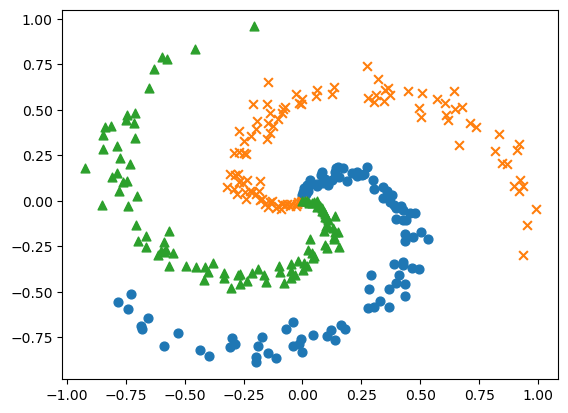

In [49]:
import sys
sys.path.append('..')
from dataset import spiral
import matplotlib.pyplot as plt

x, t = spiral.load_data()
print('x', x.shape)
print('t', t.shape)

# render data
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
  plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

### 1.4.2 신경망 구현

In [54]:
import numpy as np

class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size):
    """2층 신경망
    
    초기화 메서드는 3개의 인수를 받는다. input_size는 입력층의 뉴런 수,
    hidden_size는 은닉층의 뉴런 수, output_size는 출력층의 뉴런 수이다.
    메서드 안에서는 우선 편향을 영벡터(0으로 채워진 벡터)로 초기화하고, 가중치는 정규분포를 따르는 무작위 값으로 초기화한다.
    
    첫번째 계층은 가중치 W1과 편향 b1을 인수로 받아 Affine 계층을 생성한다.
    두번째 계층은 활성화 함수인 Sigmoid 계층이다.
    세번째 계층은 가중치 W2와 편향 b2를 인수로 받아 Affine 계층을 생성한다.
    
    손실 계층은 SoftmaxWithLoss 계층을 사용한다.
    
    마지막으로 모든 가중치와 기울기를 리스트에 모은다. 

    Args:
        input_size (int): 입력층의 뉴런 수
        hidden_size (int): 은닉층의 뉴런 수
        output_size (int): 출력층의 뉴런 수
    """
    I, H, O = input_size, hidden_size, output_size
    
    # 가중치와 편향을 초기화한다.
    
    W1 = 0.01 * np.random.randn(I, H)
    b1 = np.zeros(H)
    W2 = 0.01 * np.random.randn(H, O)
    b2 = np.zeros(O)
    
    # 계층 생성
    self.layers = [
      Affine(W1, b1),
      Sigmoid(),
      Affine(W2, b2)
    ]
    
    self.loss_layer = SoftmaxWithLoss()
    
    # 모든 가중치와 기울기를 리스트에 모은다.
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
      
  def predict(self, x):
    """예측(추론)

    Args:
        x (ndarray): 입력

    Returns:
        ndarray: 출력
    """
    for layer in self.layers:
      print(f"layer: {layer}")
      x = layer.forward(x)
    return x
  
  def forward(self, x, t):
    """순전파

    Args:
        x (ndarray): 입력
        t (ndarray): 정답 레이블

    Returns:
        float: 손실
    """
    print(f"Start forward")
    score = self.predict(x)
    loss = self.loss_layer.forward(score, t)
    return loss
  
  def backward(self, dout=1):
    """역전파

    Args:
        dout (int, optional): 미분값. Defaults to 1.

    Returns:
        ndarray: 기울기
    """
    print(f"Start backward")
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      print(f"layer: {layer}")
      dout = layer.backward(dout)
    return dout

### 1.4.3 학습용 코드

학습 데이터를 읽어 들이고, 신경망과 옵티마이저를 생성한다.

In [55]:
# 하이퍼파라미터 설정
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

# 데이터 읽기, 모델과 옵티마이저 생성
x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate) # 확률적 경사 하강법

# 학습에 사용하는 변수
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

# 학습 시작
for epoch in range(max_epoch):
  # 데이터 섞기
  idx = np.random.permutation(data_size)
  x = x[idx]
  t = t[idx]
  
  for iters in range(max_iters):
    batch_x = x[iters*batch_size:(iters+1)*batch_size]
    batch_t = t[iters*batch_size:(iters+1)*batch_size]
    
    # 기울기를 구해 매개변수 갱신
    loss = model.forward(batch_x, batch_t)
    model.backward()
    optimizer.update(model.params, model.grads)
    
    total_loss += loss
    loss_count += 1
    
    # 정기적으로 학습 경과 출력
    if (iters+1) % 10 ==0:
      avg_loss = total_loss / loss_count
      print("| 에폭 %d | 반복 %d / %d | 손실 %.2f" % (epoch + 1, iters + 1, max_iters, avg_loss))
      loss_list.append(avg_loss)
      total_loss, loss_count = 0, 0


Start forward
layer: <__main__.Affine object at 0x7f2320702f90>
layer: <__main__.Sigmoid object at 0x7f23201f0ad0>
layer: <__main__.Affine object at 0x7f232025a650>
Start backward
layer: <__main__.Affine object at 0x7f232025a650>
layer: <__main__.Sigmoid object at 0x7f23201f0ad0>
layer: <__main__.Affine object at 0x7f2320702f90>
Start forward
layer: <__main__.Affine object at 0x7f2320702f90>
layer: <__main__.Sigmoid object at 0x7f23201f0ad0>
layer: <__main__.Affine object at 0x7f232025a650>
Start backward
layer: <__main__.Affine object at 0x7f232025a650>
layer: <__main__.Sigmoid object at 0x7f23201f0ad0>
layer: <__main__.Affine object at 0x7f2320702f90>
Start forward
layer: <__main__.Affine object at 0x7f2320702f90>
layer: <__main__.Sigmoid object at 0x7f23201f0ad0>
layer: <__main__.Affine object at 0x7f232025a650>
Start backward
layer: <__main__.Affine object at 0x7f232025a650>
layer: <__main__.Sigmoid object at 0x7f23201f0ad0>
layer: <__main__.Affine object at 0x7f2320702f90>
Start f

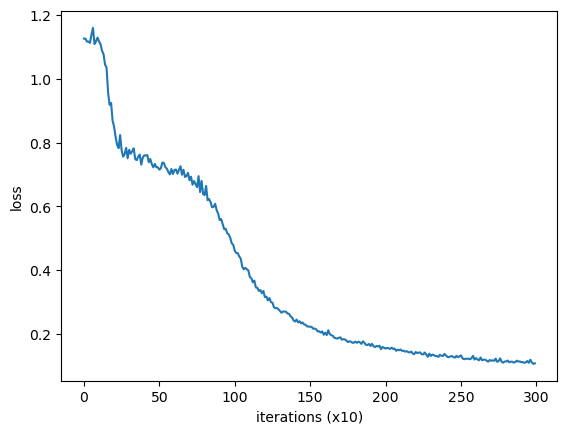

layer: <__main__.Affine object at 0x7f2320702f90>
layer: <__main__.Sigmoid object at 0x7f23201f0ad0>
layer: <__main__.Affine object at 0x7f232025a650>


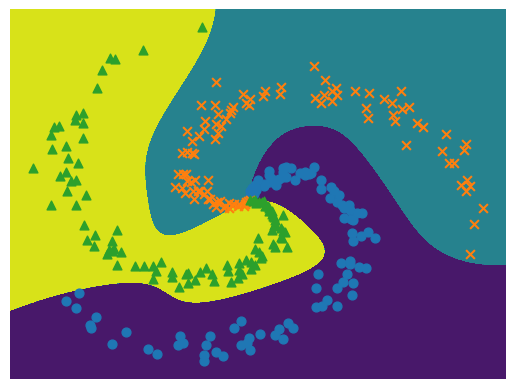

In [56]:
# 学習結果のプロット
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('iterations (x10)')
plt.ylabel('loss')
plt.show()

# 境界領域のプロット
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# データ点のプロット
x, t = spiral.load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

학습을 진행할 수록 손실이 줄어들고 있다.

신경망은 '나선형' 패턴을 올바르게 파악했다.